In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from model_very_simple_conv_32 import ConvNet


DIR_PATH = os.getcwd() + '/../'

/vol/bitbucket/hzd21/msc_project/env_pyrep/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check data

colors = (
    'FF0000',
    '00FF00',
    '0000FF',
    )


for col in colors:
    demo_data = np.load(f'{DIR_PATH}data/demo_reach_cuboid_{col}_camera32.npz')
    for k in demo_data.keys():
        print(col, k, demo_data[k].shape, demo_data[k].dtype)

FF0000 demo_image_sequences (31329, 32, 32, 3) uint8
FF0000 demo_action_sequences (31329, 3) float64
FF0000 step_marker (251,) int64
00FF00 demo_image_sequences (31329, 32, 32, 3) uint8
00FF00 demo_action_sequences (31329, 3) float64
00FF00 step_marker (251,) int64
0000FF demo_image_sequences (31329, 32, 32, 3) uint8
0000FF demo_action_sequences (31329, 3) float64
0000FF step_marker (251,) int64


In [17]:
class DemoDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.x = torch.as_tensor(data_x, dtype=torch.float32).permute(0, 3, 1, 2)
        self.y = torch.as_tensor(data_y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def normalize(x_data, y_data, max_speed_linear=0.1, max_speed_angular=0.2):
    """"Normalize input images with values between 0 and 1,
    and outputs with values between -1 and 1.
    """
    normal_x = x_data / 255
    n_outputs = y_data.shape[1]
    if n_outputs == 3:
        normal_y = y_data / max_speed_linear
    else:
        normal_y = y_data / np.array([3*[max_speed_linear] + 3*[0.05*0.2]])
    return normal_x, normal_y



def mask_images(imgs, img_size=32, mask_size_range=(5, 20)):
    """Augment image data by partially masking each image with a squared mask of random color,
    random size and placed at a random position in the image

    Args:
        imgs (array): images to be augmented
        img_size (int): size of the images (assumed square)
        mask_size_range: (minimum, maximum) size that the mask can take

    """
    new_imgs = imgs.copy()
    for im in new_imgs:
        mask_size = np.random.randint(mask_size_range[0], mask_size_range[1])
        mask_pos = np.random.randint(0, img_size-mask_size+1, 2)
        color = np.random.randint(0, 256, 3)
        im[mask_pos[0]:mask_pos[0]+mask_size, mask_pos[1]:mask_pos[1]+mask_size] = color
    return new_imgs

def get_name(color_hex):
    return f"demo_reach_cuboid_{color_hex}_camera32.npz"

def prepare_data(name, n_trajectories, train_prop, n_augmented):
    demo_data = np.load(f'{DIR_PATH}data/{name}')
    assert n_trajectories < len(demo_data['step_marker']), "Not enough trajectories"

    # Seperate training and validation set
    n_train = int(train_prop * n_trajectories)
    n_val = n_trajectories - n_train

    print(f"n_train={n_train}, n_val={n_val}")

    idx_train = demo_data['step_marker'][n_train]
    idx_val = demo_data['step_marker'][n_trajectories]

    train_imgs = demo_data['demo_image_sequences'][:idx_train]
    train_act = demo_data['demo_action_sequences'][:idx_train]
    val_imgs = demo_data['demo_image_sequences'][idx_train:idx_val]
    val_acts = demo_data['demo_action_sequences'][idx_train:idx_val]
    train_imgs.shape, train_act.shape, val_imgs.shape, val_acts.shape

    # Data augmentation if n_augmented > 0
    masked_train_images = [mask_images(train_imgs) for _ in range(n_augmented)]
    train_x = np.concatenate([train_imgs] + masked_train_images)
    train_y = np.concatenate([train_act] * (1 + n_augmented))


    masked_val_images = [mask_images(val_imgs) for _ in range(n_augmented)]
    val_x = np.concatenate([val_imgs] + masked_val_images)
    val_y = np.concatenate([val_acts] * (1 + n_augmented))

    # Normalize data
    normal_train_x, normal_train_y = normalize(train_x, train_y)
    normal_val_x, normal_val_y = normalize(val_x, val_y)

    train_set = DemoDataset(normal_train_x, normal_train_y)
    v_set = DemoDataset(normal_val_x, normal_val_y)

    return train_set, v_set

In [18]:
# Check datasets

def check(train_set, v_set):
    print(train_set.x.shape, train_set.y.shape, v_set.x.shape, v_set.y.shape, sep='\n')

    for i in range(3):
        print(train_set.x[:, i].amin(), train_set.x[:, i].amax())
        
    for i in range(3):
        print(train_set.y[:, i].amin(), train_set.y[:, i].amax())


    n_display_examples, n_rows, n_cols = 96, 8, 12
    #ids = np.random.choice(len(train_set), n_display_examples, replace=False)
    ids = np.arange(0, 96*10, 10)

    plt.figure()
    for i, id in enumerate(ids):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(train_set.x[id].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

In [19]:
name = 'demo_reach_blue32x32_ori.npz'
train_set, v_set = prepare_data(name, 200, 0.8, 0)

n_train=160, n_val=40


In [26]:
demo_data = np.load(f'{DIR_PATH}data/{name}')

end_seq1 = demo_data['step_marker'][1]



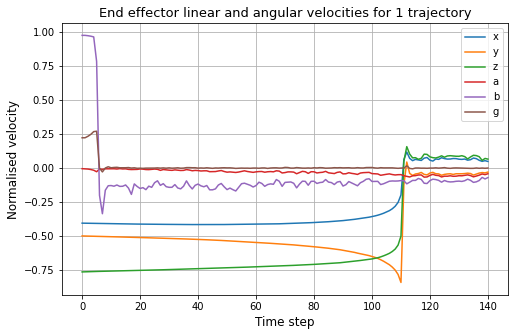

In [50]:
plt.figure(figsize=[8, 5])

plt.title('End effector linear and angular velocities for 1 trajectory', fontsize=13)
plt.ylabel('Normalised velocity', fontsize=12)
plt.xlabel('Time step', fontsize=12)
plt.plot(train_set.y[:end_seq1])
plt.legend(['x', 'y', 'z', 'a', 'b', 'g'])
plt.grid()

plt.savefig(DIR_PATH+"data/velocities_with_ori_during_1_traj")

In [17]:
%matplotlib inline
for col in colors[-1:]:
    train_set, v_set = prepare_data(col, 200, 0.8, 0)
    check(train_set, v_set)

Using matplotlib backend: <object object at 0x7f4554408980>
n_train=160, n_val=40
torch.Size([22161, 3, 32, 32])
torch.Size([22161, 6])
torch.Size([5588, 3, 32, 32])
torch.Size([5588, 6])
tensor(0.) tensor(0.8549)
tensor(0.) tensor(0.8353)
tensor(0.) tensor(0.9686)
tensor(-0.5741) tensor(0.9681)
tensor(-0.9558) tensor(0.9837)
tensor(-1.0000) tensor(0.3335)


In [19]:
n_display_examples, n_rows, n_cols = 96, 8, 12
#ids = np.random.choice(len(train_set), n_display_examples, replace=False)
ids = np.arange(0, 96*10, 10)

plt.figure()
for i, id in enumerate(ids):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(train_set.x[id].permute(1, 2, 0))
    plt.axis('off')


In [6]:
imgs_stack = []

for col in colors:
    train_set, v_set = prepare_data(col, 200, 0.8, 0)
    n = 1000
    ids = np.random.choice(len(train_set), n, replace=False)
    imgs_stack.append(train_set.x[ids].permute(0, 2, 3, 1).numpy())

imgs = np.concatenate(imgs_stack)

n_train=160, n_val=40
n_train=160, n_val=40
n_train=160, n_val=40


In [7]:
imgs.shape

(3000, 32, 32, 3)

In [8]:
idx = np.random.permutation(len(imgs))
shuffled_imgs = imgs[idx].copy()

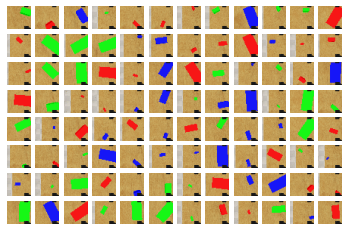

In [24]:
%matplotlib inline
n_display_examples, n_rows, n_cols = 96, 8, 12
#ids = np.random.choice(len(train_set), n_display_examples, replace=False)
ids = np.arange(0, 96, 1)

for i, id in enumerate(ids):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(shuffled_imgs[id])
    plt.axis('off')

plt.savefig(DIR_PATH+"data/image_rgb_cuboids_shuffled")

In [1]:
from sklearn.cluster import KMeans

In [10]:
X = shuffled_imgs.reshape(3000, 3*32*32)

In [11]:
scores = []

for i in range(1, 16):
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(X)
    s = kmeans.score(X)
    scores.append(s)

In [15]:
scores.shape

(15,)

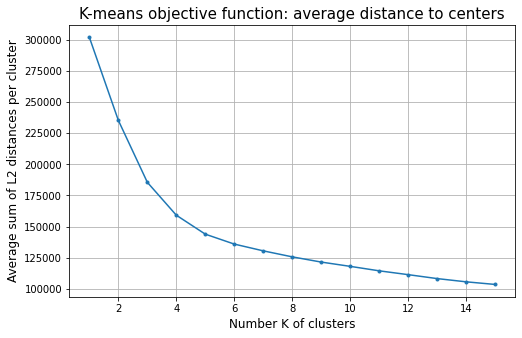

In [44]:
scores_array = np.array(scores)
plt.figure(figsize=[8, 5])
plt.plot(range(1, 16), -scores, '.-')
plt.title("K-means objective function: average distance to centers", fontsize=15)
plt.xlabel('Number K of clusters', fontsize=12)
plt.ylabel('Average sum of L2 distances per cluster', fontsize=12)
plt.grid()

plt.savefig(DIR_PATH+'data/kmeans_cluster_scores.jpg')

In [25]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(X)

bags = [[] for _ in range(n_clusters)]
for i, id in enumerate(labels):
    bags[id].append(X[i].reshape(32, 32, 3))

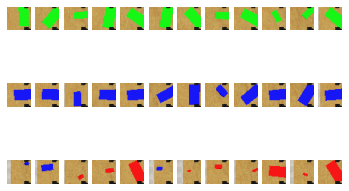

In [38]:
plt.figure()
n_examples = 12
for i in range(n_clusters):
    for j in range(n_examples):
        plt.subplot(n_clusters, n_examples, i*n_examples+j+1)
        plt.imshow(bags[i][j+11])
        plt.axis('off')

plt.savefig(DIR_PATH+"data/image_rgb_cuboids_3_clusters")